**MASC 520 Final Project** \
*Discrete Control of a Car in a Simulated Environment with Deep-Q Reinforcement Learning*


Imports and Environment Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import numpy as np
from collections import deque
import torch.optim as optim
import gymnasium as gym
import pandas as pd

In [2]:
env = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.95, domain_randomize=False, continuous=False)
env = gym.wrappers.GrayscaleObservation(env)
env = gym.wrappers.ResizeObservation(env, (84,84))
env = gym.wrappers.FrameStackObservation(env, 4)
env = gym.wrappers.RecordVideo(env, video_folder="./example_videos", episode_trigger=lambda e: e % 10 == 0)

/Users/helen/Library/Python/3.9/lib/python/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/helen/Documents/AME520/project/deepQ-learned-car-control/example_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Neural Network Architecture

In [3]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        # Convolutional Neural Network
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        # Compute size of the conv output
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            conv_out_size = self.conv(dummy_input).view(1, -1).size(1)

        # Regular Feed Fwd NN to get best action
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

Source Reference: \
HK, Abhimanyu. “Mastering Deep Q-Learning with Pytorch: A Comprehensive Guide.” Medium, Medium, 13 Mar. 2024, medium.com/@hkabhi916/mastering-deep-q-learning-with-pytorch-a-comprehensive-guide-a7e690d644fc.  

In [4]:
class DQNAgent:
    def __init__(self, input_shape, num_actions, lr, gamma, epsilon, epsilon_decay, buffer_size):
        self.action_dim = num_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=buffer_size)

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else
            "mps" if torch.backends.mps.is_available() else
            "cpu"
        )

        self.model = DQN(input_shape, num_actions).to(self.device)
        self.target_model = DQN(input_shape, num_actions).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())  # Sync weights initially
        self.target_model.eval()

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.update_count = 0
        self.target_update_freq = 1000  # update every 1000 steps

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_dim)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)  # [1, C, H, W]
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()

    #Function to keep track of previous moves and rewards in the current episode
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Back Propogation Function: Samples a subset of the memory (minibatch) and calulates the predicted and target Q-values to compute loss and 
    # update the model.
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        # Get random subset of memory to use in back prop.
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.tensor(np.array(states), dtype=torch.float32).to(self.device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        # Get Q-values for the current states from the main model
        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Use the target model to get max Q-values for the next states (no gradients for target model)
        next_q_values = self.target_model(next_states).detach().max(1)[0]  # detach to prevent gradients from flowing into the target network

        # Calculate the target Q-values using the reward and discounted future Q-values (Bellman Equation)
        targets = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute loss (MSE between current model and target model)
        loss = nn.MSELoss()(q_values, targets)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)  # Gradient clipping
        self.optimizer.step() # Updates weights

        # Update epsilon (exploration rate)
        if self.epsilon > 0.001:
            self.epsilon *= self.epsilon_decay

        # Periodically update the target model (every 1000 steps)
        self.update_count += 1
        if self.update_count % self.target_update_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())
    # Train the model for a specified number of episodes
    def train(self, env, num_episodes, batch_size, min_buffer_size):
        rewards = []
        for episode in range(num_episodes):
            obs, _ = env.reset()
            state = obs.astype(np.float32) / 255.0
            total_reward = 0
            step = 0
            done = False

            while not done:
                # Take action
                action = self.act(state)
                next_obs, reward, terminated, truncated, _ = env.step(action)

                # Save output of action
                done = terminated or truncated 
                next_obs= next_obs.astype(np.float32) / 255.0
                self.remember(state, action, reward, next_obs, done)

                # Back propagate and update NN
                if len(self.memory) > min_buffer_size:
                    self.replay(batch_size)

                # Update state and reward tracker
                state = next_obs
                    
                total_reward += reward
                step += 1

                if total_reward < -200:
                    break

            print(f"Episode {episode + 1} — Total Reward: {total_reward}")
            rewards.append(total_reward)
        return rewards
    
    # Test the model by using an epsilon of 0 (no exploration)
    def test(self, env, episodes=5, save_video=False):
        rewards = []
        self.epsilon = 0.0  # Greedy policy

        if save_video:
            from gymnasium.wrappers import RecordVideo
            env = RecordVideo(env, video_folder="./test_videos", name_prefix="car_racing_test",episode_trigger=lambda e: e == e)

        for episode in range(episodes):
            obs, _ = env.reset()
            state = obs.astype(np.float32) / 255.0
            total_reward = 0
            done = False
            step = 0

            # Same as training loop with no back propogation / model updating
            while not done:

                action = self.act(state)
                next_obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                next_state = next_obs.astype(np.float32) / 255.0
                state = next_state
                total_reward += reward
                step += 1

            print(f"Test Episode {episode + 1} — Total Reward: {total_reward}")
            rewards.append(total_reward)

        env.close()
        return rewards


Parameters and Initialization

In [5]:
obs, _ = env.reset()
state_dim = obs.shape
action_dim = env.action_space.n
agent = DQNAgent(
    input_shape=state_dim,
    num_actions=action_dim,
    lr=0.0005,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.995,
    buffer_size=10000
)
min_buffer_size = 1000
batch_size = 32
num_episodes = 180

TRAINING

In [7]:
rewards_train = agent.train(env,num_episodes, batch_size, min_buffer_size)

Episode 1 — Total Reward: -101.52101910828011
Episode 2 — Total Reward: -66.87254901960824
Episode 3 — Total Reward: -61.631914893617456
Episode 4 — Total Reward: -72.84061433447148
Episode 5 — Total Reward: -87.57763975155207
Episode 6 — Total Reward: -32.03883495145704
Episode 7 — Total Reward: -33.64745762711479
Episode 8 — Total Reward: -34.85342019544045
Episode 9 — Total Reward: -19.54022988505793
Episode 10 — Total Reward: -31.506849315069264
Episode 11 — Total Reward: -20.529801324503918
Episode 12 — Total Reward: -49.664429530201936
Episode 13 — Total Reward: -13.04347826087007
Episode 14 — Total Reward: -45.94594594594663
Episode 15 — Total Reward: -26.199261992620702
Episode 16 — Total Reward: -34.42622950819746
Episode 17 — Total Reward: -32.83582089552313
Episode 18 — Total Reward: -7.473309608540923
Episode 19 — Total Reward: -34.93150684931578
Episode 20 — Total Reward: 172.1311475409857
Episode 21 — Total Reward: -21.348314606742314
Episode 22 — Total Reward: -74.658024

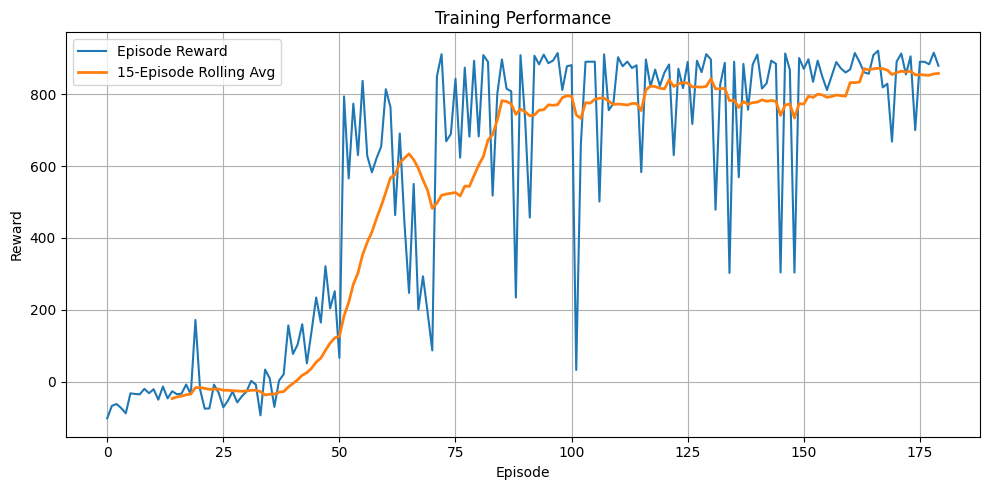

In [8]:
rolling_window = 15  # you can adjust this
rolling_avg = pd.Series(rewards_train).rolling(rolling_window).mean()

plt.figure(figsize=(10, 5))
plt.plot(rewards_train, label='Episode Reward')
plt.plot(rolling_avg, label=f'{rolling_window}-Episode Rolling Avg', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

TESTING

In [10]:
rewards_test = agent.test(env, 10, True)

/Users/helen/Library/Python/3.9/lib/python/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/helen/Documents/AME520/project/deepQ-learned-car-control/test_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Test Episode 1 — Total Reward: 698.561151079122
Test Episode 2 — Total Reward: 686.8852459016275
Test Episode 3 — Total Reward: 683.018867924513
Test Episode 4 — Total Reward: 622.6027397260153
Test Episode 5 — Total Reward: 861.5384615384475
Test Episode 6 — Total Reward: 742.2712933753828
Test Episode 7 — Total Reward: 647.1698113207424
Test Episode 8 — Total Reward: 885.0187265917498
Test Episode 9 — Total Reward: 643.9024390243798
Test Episode 10 — Total Reward: 840.5594405594276


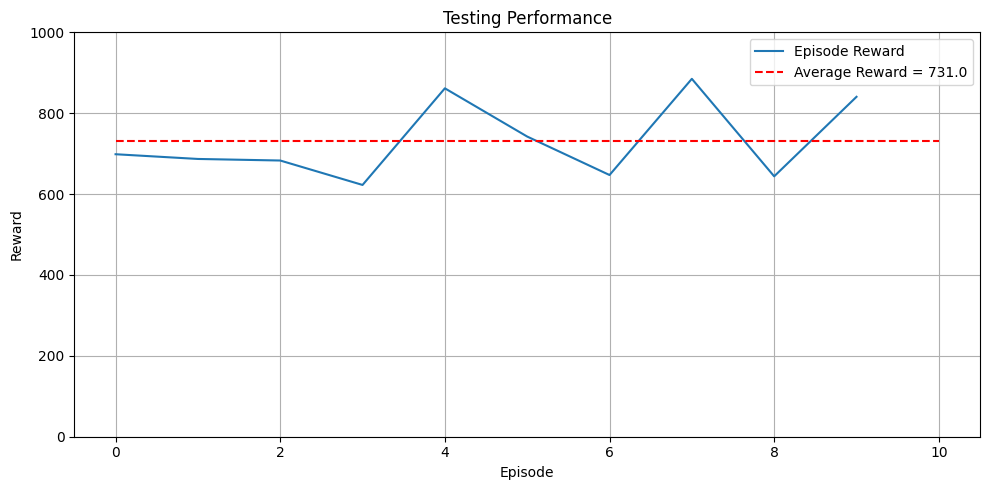

In [11]:
avg = np.mean(rewards_test)
plt.figure(figsize=(10, 5))
plt.plot(rewards_test, label='Episode Reward')
plt.hlines(avg, xmin=0, xmax=len(rewards_test),label=f'Average Reward = {np.round(avg)}', colors = "r",linestyles="--")
plt.ylim((0,1000))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Testing Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()